In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK

In [109]:
import numpy as np
import os
import cv2
import glob

UPPER_BOUND = 400
LOWER_BOUND = -1000

import SimpleITK
import pandas as pd
from torch.utils.data import Dataset


def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax


def crop(image):
    ymin,ymax,xmin,xmax = bbox(image > 0.5)
    return image[ymin:ymax, xmin:xmax]


def normalization(volume, axis=None):
    mean = np.mean(volume, axis=axis)
    std = np.std(volume, axis=axis)
    norm_volume = (volume - mean) / std
    return norm_volume


class TemporalMixDataset(Dataset):
    def __init__(self, csv_file, transform):
        df = pd.read_csv(csv_file)
        df["slice_idx"] = df["image"].apply(lambda x: int(x.split("/")[-1].split(".")[1]))
        df["max_slice_idx"] = df.groupby("patient_id")["slice_idx"].transform("max")
        df["min_slice_idx"] = df.groupby("patient_id")["slice_idx"].transform("min")
        self.images = df["image"].values
        self.patient_ids = df["patient_id"].values
        self.max_slice_idxs = df["max_slice_idx"].values
        self.min_slice_idxs = df["min_slice_idx"].values
        self.slice_idxs = df["slice_idx"].values

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        patient_id = self.patient_ids[idx]
        max_slice_idx = self.max_slice_idxs[idx]
        min_slice_idx = self.min_slice_idxs[idx]
        slice_idx = self.slice_idxs[idx]

        if slice_idx == min_slice_idx:
            rnd_temporal_idx = 0
        elif slice_idx == min_slice_idx + 1:
            rnd_temporal_idx = np.random.choice([-1, 0], size=1)[0]
        elif slice_idx == max_slice_idx:
            rnd_temporal_idx = 0
        elif slice_idx == max_slice_idx - 1:
            rnd_temporal_idx = np.random.choice([0, 1], size=1)[0]
        else:
            rnd_temporal_idx = np.random.choice([-2, -1, 0, 1, 2], size=1)[0]

        mix_idx = slice_idx + rnd_temporal_idx
        image = np.load(image_path)
        if mix_idx == slice_idx: # No mix
            label = rnd_temporal_idx + 2
            ymin, ymax, xmin, xmax = bbox(image > 0.5)
            image = image[ymin:350, xmin:xmax]
        else:
            mix_image_path = image_path.replace(f".{slice_idx}.", f".{mix_idx}.")
            mix_image = np.load(mix_image_path)

            cutout_size = 50

            ymin, ymax, xmin, xmax = bbox(image > 0.5)
            for i in range(20):
                ystart = np.random.randint(ymin, 350 - cutout_size)
                xstart = np.random.randint(xmin, xmax - cutout_size)
                # mix a part of two images
                image[ystart:ystart + cutout_size, xstart:xstart + cutout_size] = mix_image[ystart:ystart + cutout_size, xstart:xstart + cutout_size]
            image = image[ymin:350, xmin:xmax]
            label = rnd_temporal_idx + 2

        image = np.stack((image, image, image), axis=-1)

        if self.transform:
            image = self.transform(image=image)["image"]
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return {
            "images": image,
            "targets": label
        }


class StructSegTrain2D(Dataset):

    def __init__(self,
                 csv_file,
                 transform
                 ):
        df = pd.read_csv(csv_file)
        self.transform = transform
        self.images = df['image'].values
        self.masks = df['mask'].values

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        mask = self.masks[idx]

        # Replace with 2d chest
        # image = image.replace('Thoracic_OAR_2d', 'Thoracic_OAR_2d_lung')
        # mask = mask.replace('Thoracic_OAR_2d', 'Thoracic_OAR_2d_lung')

        image = np.load(image)
        mask = np.load(mask)

        ymin, ymax, xmin, xmax = bbox(image > 0.5)
        image = image[ymin:350, xmin:xmax]
        mask = mask[ymin:350, xmin:xmax]

        image = np.stack((image, image, image), axis=-1).astype(np.float32)

        if self.transform:
            transform = self.transform(image=image, mask=mask)
            image = transform['image']
            mask = transform['mask']

        image = np.transpose(image, (2, 0, 1))
        mask = mask.astype(np.int)

        return {
            'images': image,
            'targets': mask
        }


def norm_image(image):
    image = (image - LOWER_BOUND) / (UPPER_BOUND - LOWER_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    image = image.astype(np.float32)
    return image


def load_ct_images(path):
    image = SimpleITK.ReadImage(path)
    image = SimpleITK.GetArrayFromImage(image).astype(np.float32)
    return image


class CHAOSDataset(Dataset):

    def __init__(self,
                 ct_dir,
                 pred_dir,
                 transform
                 ):

        ct_files = glob.glob(ct_dir + "/*/DICOM_anon/*.dcm")
        patient_ids = [x.split("/")[-3] for x in ct_files]
        file_names = [x.split("/")[-1].split(".")[0] for x in ct_files]
        gt_files = [
            pred_dir + f"/{patient_id}/{filename}.npy" for patient_id, filename in zip(patient_ids, file_names)
        ]

        self.transform = transform
        self.images = ct_files
        self.targets = gt_files
        # print(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # print(idx)

        image = self.images[idx]
        image = load_ct_images(image)[0]
        image = norm_image(image)

        ymin, ymax, xmin, xmax = bbox(image > 0.5)
        image = image[ymin:ymax, xmin:xmax]
        # mask = mask[ymin:350, xmin:xmax]

        target = self.targets[idx]
        target = np.load(target)
        labels = np.unique(target)
        target = np.zeros((7, ), dtype=np.float32)
        for label in labels:
            target[label] = 1

        # print(target)

        image = np.stack((image, image, image), axis=-1).astype(np.float32)

        if self.transform:
            transform = self.transform(image=image)
            image = transform['image']

        image = np.transpose(image, (2, 0, 1))

        return {
            'images': image,
            'targets': target
        }


class Brats2019Dataset(Dataset):

    def __init__(self,
                 root_dir,
                 csv_file,
                 transform,
                 data="WT"
                 ):

        df = pd.read_csv(csv_file)
        self.images = glob.glob(root_dir + f"/*/*/images/*.npz")
        self.images = [image for image in self.images if image.split("/")[-3] in df["BraTS_2019_subject_ID"].values]
        self.transform = transform
        self.data = data
        print(self.data)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = image.replace("images", "masks")

        image = np.load(image)["arr_0"][:, :, 0]
        mask = np.load(mask)["arr_0"]
        # print("Before ", np.unique(mask))
        label1 = np.where(mask == 1)
        label2 = np.where(mask == 2)
        label3 = np.where(mask == 4)

        if self.data == "WT":
            mask[label1] = 1
            mask[label2] = 1
            mask[label3] = 1
        elif self.data == "TC":
            mask[label1] = 1
            mask[label2] = 0
            mask[label3] = 1
        else:
            mask[label1] = 0
            mask[label2] = 0
            mask[label3] = 1
        # mask = np.expand_dims(mask, axis=0)
        # print(mask.shape)
        # print("After ", np.unique(mask))

        # image = image / image.max()
        image = normalization(image)
        image = np.stack((image, image, image), axis=-1)

        # image = np.stack((image, image, image), axis=-1).astype(np.float32)
        # image = np.transpose(image, (1, 2, 0)).astype(np.float32)

        if self.transform:
            transform = self.transform(image=image, mask=mask)
            image = transform['image']
            mask = transform["mask"]

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.expand_dims(mask, axis=0).astype(np.float32)
        # mask = mask.astype(np.int)

        return {
            'images': image,
            'targets': mask
        }


class BratsTemporalMixDataset(Brats2019Dataset):
    def __init__(self,
                 root_dir,
                 csv_file,
                 transform,
                 ):
        super(BratsTemporalMixDataset, self).__init__(
            root_dir,
            csv_file,
            transform
        )

        df = pd.DataFrame({
            "image": self.images
        })
        df["patient_id"] = df["image"].apply(lambda x: x.split("/")[-3])
        df["slice_idx"] = df["image"].apply(lambda x: int(x.split("/")[-1].split(".")[0].split("_")[1]))
        df["max_slice_idx"] = df.groupby("patient_id")["slice_idx"].transform("max")
        df["min_slice_idx"] = df.groupby("patient_id")["slice_idx"].transform("min")
        self.images = df["image"].values
        self.patient_ids = df["patient_id"].values
        self.max_slice_idxs = df["max_slice_idx"].values
        self.min_slice_idxs = df["min_slice_idx"].values
        self.slice_idxs = df["slice_idx"].values

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        patient_id = self.patient_ids[idx]
        max_slice_idx = self.max_slice_idxs[idx]
        min_slice_idx = self.min_slice_idxs[idx]
        slice_idx = self.slice_idxs[idx]
        
        print(slice_idx, min_slice_idx, max_slice_idx)
        
        if slice_idx == min_slice_idx:
            rnd_temporal_idx = np.random.choice([0, 3, 5], size=1)[0]
        elif slice_idx >= min_slice_idx + 3 and slice_idx < min_slice_idx + 5:
            rnd_temporal_idx = np.random.choice([-3, 0, 3, 5], size=1)[0]
        elif slice_idx >= min_slice_idx + 5 and slice_idx <= max_slice_idx - 5:
            rnd_temporal_idx = np.random.choice([-5, -3, 0, 3, 5], size=1)[0]
        elif slice_idx > max_slice_idx - 5 and slice_idx <= max_slice_idx - 3:
            rnd_temporal_idx = np.random.choice([-5, -3, 0, 3], size=1)[0]
        elif slice_idx > max_slice_idx - 3:
            rnd_temporal_idx = np.random.choice([-5, -3, 0], size=1)[0]

        mix_idx = slice_idx + rnd_temporal_idx
        image = np.load(image_path)["arr_0"]
        ymin, ymax, xmin, xmax = bbox(image > 0)
        diff1 = ymax - ymin
        diff2 = xmax - xmin
        if diff1 > 100 and diff2 > 100:
            if mix_idx == slice_idx: # No mix
                label = 0
            else:
                mix_image_path = image_path.replace(f"_{slice_idx}.", f"_{mix_idx}.")
                mix_image = np.load(mix_image_path)["arr_0"]

                cutout_size = 20
                for i in range(20):
                    ystart = np.random.randint(ymin, ymax - cutout_size)
                    xstart = np.random.randint(xmin, xmax - cutout_size)
                    # mix a part of two images
                    image[ystart:ystart + cutout_size, xstart:xstart + cutout_size] = mix_image[ystart:ystart + cutout_size,
                                                                                      xstart:xstart + cutout_size]
                    image = cv2.rectangle(
                        image, 
                        (ystart, xstart), 
                        (ystart + cutout_size, xstart + cutout_size),
                        thickness=1,
                        color=(255, 255, 0)
                    )
                # image = image[ymin:350, xmin:xmax]
                # label = rnd_temporal_idx + 2
                if rnd_temporal_idx == -5:
                    label = 0
                elif rnd_temporal_idx == -3:
                    label = 1
                elif rnd_temporal_idx == 0:
                    label = 2
                elif rnd_temporal_idx == 3:
                    label = 3
                elif rnd_temporal_idx == 5:
                    label = 4
                else:
                    raise ValueError("Invalid valude")
        else:
            label = 2 # No mix
            
        print(label)

        image = normalization(image)
        image = image[ymin:ymax, xmin:xmax]

        if self.transform:
            image = self.transform(image=image)["image"]
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return {
            "images": image,
            "targets": label
        }

In [110]:
dataset = BratsTemporalMixDataset(
    root_dir="../data/brats2019/training_preprocess/",
    csv_file="../csv/brats_train.csv",
    transform=None
)

WT


In [124]:
image = dataset[200]["images"]

65 0 94
1


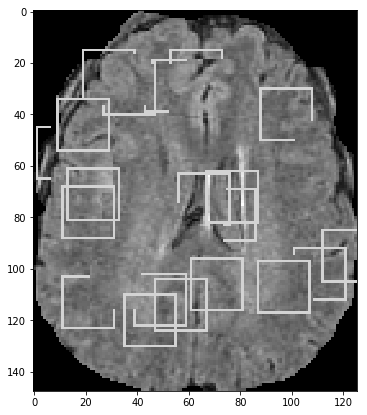

In [125]:
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, 0], cmap="gray")

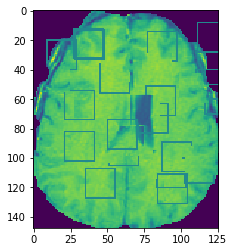

In [120]:
plt.imshow(image[:, :, 1])

In [ ]:
plt.imshow(image[:, :, 2])

In [ ]:
plt.imshow(image[:, :, 3])